In [99]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker
from unidecode import unidecode_expect_ascii

In [2]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,25)
staff_number = 6
tournament_number = 20

# Faza 1 - przygotowanie

## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [4]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))
prompt_tournaments = pd.read_csv(file_path('turnieje.csv'), delimiter=';')

## Tabela prompt_dates

In [5]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [6]:
generated_dates = gen_dates(shop_open_date, today)

In [7]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')

## Ruch - dni

In [8]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(A+B*i+dd)

In [9]:
prompt_dates['volume_base'] = volume_base

In [10]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [11]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,0.4*v_base+szum))

prompt_dates['volume_rental'] = volume_rental

In [12]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7.00,7.00,2.800
1,2021-06-02,Środa,6.01,5.01,2.404
2,2021-06-04,Piątek,11.02,11.02,3.408
3,2021-06-05,Sobota,11.03,11.03,6.412
4,2021-06-07,Poniedziałek,8.04,10.04,5.216


## Tabela procentowa z godzinami

In [13]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [14]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

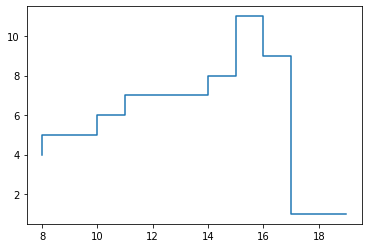

In [15]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [16]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [17]:
sum(hours_prompt['Natężenie'])

1.0

## Gry

In [18]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [19]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,"Buła, Pizza, Kot, Ser, Koza",karciana,towarzyska,"Buła, Pizza, Kot, Ser, Koza - gra równie szalo...",NIE,32.99,5.0,NaN
2,Jungle Speed Eco,inna,towarzyska,"Odkrywaj symbole, patrz uważnie i jak najszybc...",TAK,60.90,NaN,10
3,Czarne Historie,karciana,towarzyska,"Czarne historie to zestaw 50 elektryzujących, ...",NIE,30.90,8.0,NaN
4,Ubongo,planszowa,familijna,Szalona gra która rozkręci Twój mózg! Ubongo t...,NIE,81.46,NaN,NaN


In [20]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [21]:
sum(prompt_games['wagi'])

1.0000000000000002

_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [100]:
id_generator = lambda n: [*range(1, n+1)]


gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n=6):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.').apply(lambda x: unidecode_expect_ascii(x))
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False) + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60)))
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [101]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'staff_id': [*id_generator(n)],
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['city'] = np.full((1, staff.shape[0]), 'Wrocław')[0]
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [102]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
0,1,GABRIELA,PTASZEK,450390806,GABRIELA.PTASZEK@onet.pl,Wrocław,3820.80,True,F,2021-06-01,NaN,2021-06-01 14:09:01
1,2,MARIA,BOCHYŃSKA,787829364,MARIA.BOCHYNSKA@gmail.com,Wrocław,3648.37,False,F,2021-06-01,NaN,2021-06-01 14:09:01
2,3,ADRIAN,MILEWSKI,697022070,ADRIAN.MILEWSKI@polska.pl,Wrocław,3598.22,False,M,2021-06-01,NaN,2021-06-01 14:09:01
3,4,LUCYNA,SOSNOWSKA,692879892,LUCYNA.SOSNOWSKA@poczta.fm,Wrocław,3672.16,False,F,2021-06-01,NaN,2021-06-01 14:09:01
4,5,NORBERT,FRONTCZAK,457494135,NORBERT.FRONTCZAK@poczta.fm,Wrocław,NaN,False,M,2021-06-01,2022-04-08,2022-04-08 14:09:01
5,6,IRENA,PIOTROWSKA,694898134,IRENA.PIOTROWSKA@o2.pl,Wrocław,3587.99,False,F,2022-05-08,NaN,2022-05-08 14:09:01


## Godziny pracy

In [57]:
hours = range(8,20)
weekdays = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota']
workers = staff.staff_id
w = []
h = []
for i in range(8,20):
    for j in weekdays:
        w.append(j)
        h.append(i)
wk = []
for i in h:
    if i < 14:
        wk.append((1,2))
    else:
        wk.append((3,4,6))
        
weekday_hour_worker = pd.DataFrame({
    'weekdays': w, 
    'hour': h, 
    'staff': wk
})

In [58]:
weekday_hour_worker

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"
...,...,...,...
67,Wtorek,19,"(3, 4, 6)"
68,Środa,19,"(3, 4, 6)"
69,Czwartek,19,"(3, 4, 6)"
70,Piątek,19,"(3, 4, 6)"


## Związki

In [27]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [28]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_time_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = [*range(1, n+1)]
    df['partner_id'] = [*range(1, n+1)]
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [29]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
0,1,1,M,1,5,2022-06-11 11:46:54
2,2,3,M,2,7,2022-08-17 11:27:11
8,3,6,F,3,9,2022-09-08 00:01:34
7,4,6,F,4,5,2023-02-11 01:01:55
4,5,1,M,5,8,2023-02-18 22:40:31
1,6,2,M,6,6,2023-03-29 11:57:55
3,7,6,F,7,5,2023-04-06 11:26:27
5,8,2,M,8,5,2023-05-20 05:02:09
6,9,6,F,9,5,2023-06-04 04:46:55


## Partnerzy

In [30]:
def partners_df_generator(relationships_df):
    n = relationships_df.shape[0]
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [31]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
0,1,JOANNA,F,2022-06-11 11:46:54
2,2,KACPER,M,2022-08-17 11:27:11
8,3,TADEUSZ,M,2022-09-08 00:01:34
7,4,ZDZISŁAW,M,2023-02-11 01:01:55
4,5,BARTOSZ,M,2023-02-18 22:40:31
1,6,BOGUSŁAWA,F,2023-03-29 11:57:55
3,7,PIOTR,M,2023-04-06 11:26:27
5,8,PATRYCJA,F,2023-05-20 05:02:09
6,9,MAREK,M,2023-06-04 04:46:55


## Klienci - część A

In [32]:
customers = pd.DataFrame({'customer_id': [i for i in range(1,1501)]})

## Koszty utrzymania

In [33]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(prompt_dates.loc[(prompt_dates['Data'].dt.day == day) | (prompt_dates['Data'].dt.day == day+1), 'Data'])
    base['flag'] = base['Data'].dt.to_period('M') 
    base.drop_duplicates(['flag'], keep='first', inplace=True)
    base = base.reset_index()
    return base['Data']

In [44]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'czynsz ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'czynsz')[0]
    })
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'energia elektryczna ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df

def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'woda ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'ogrzewanie ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat([staff_df[['first_name', 'last_name', 'current_salary']]]*date_df.shape[0], ignore_index=True)
    staff_name = staff_df['first_name'].str.cat(staff_df['last_name'], sep=' ')
    names = pd.concat([staff_name]*date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()['Data']
    title_first = dates.dt.month_name(locale='pl_PL').apply(lambda x: 'PENSJA ' + str(x).upper())
    title = title_first.str.cat(names, sep=' ')
    df = pd.DataFrame({
        'date': dates,
        'title': title,
        'amount': all_staff['current_salary'],
        'type': np.full((1, title.shape[0]), 'pensja')[0]
    })
    to_date = pd.to_datetime(staff_df['to_date'].loc[staff_df['to_date'].isnull() == False].values[0])
    df.loc[(df['amount'].isnull() == True) & (df['date'] < to_date), 'amount'] = round(3490 + expon.rvs(scale=100, loc=80), 2)
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame({
        'date': [],
        'title': [],
        'amount': [],
        'type': [],
        'updated_at': []
    })
    df = pd.concat([df, rent_generator(), energy_generator(), water_generator(), heat_generator(), salary_generator(staff)])
    df['updated_at'] = df['date'].apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df.sort_values(by=['updated_at'], inplace=True)
    df['payment_id'] = [*range(1, df.shape[0]+1)]
    df['invoice_id'] = [*range(1, df.shape[0]+1)]
    df['spend_id'] = [*range(1, df.shape[0]+1)]
    df = df.reindex(['spend_id', 'title', 'amount', 'type','date', 'payment_id', 'invoice_id', 'updated_at'], axis=1)
    return df

In [45]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,woda czerwiec,49.11,media,2021-06-05,1,1,2021-06-05 09:52:21
3,2,czynsz czerwiec,3250.00,czynsz,2021-06-05,2,2,2021-06-05 14:16:27
3,3,energia elektryczna czerwiec,155.43,media,2021-06-05,3,3,2021-06-05 14:50:48
1,4,PENSJA CZERWIEC OSKAR DĄBROWSKI,3703.51,pensja,2021-06-10,4,4,2021-06-10 10:48:45
0,5,PENSJA CZERWIEC JANUSZ KOZAKIEWICZ,3574.67,pensja,2021-06-10,5,5,2021-06-10 11:05:37
...,...,...,...,...,...,...,...,...
149,192,PENSJA CZERWIEC BARBARA MULARCZYK,3817.29,pensja,2023-06-10,192,192,2023-06-10 08:35:59
146,193,PENSJA CZERWIEC MARIUSZ WAŻNY,3571.01,pensja,2023-06-10,193,193,2023-06-10 09:23:02
147,194,PENSJA CZERWIEC MARCIN KUCZYŃSKI,3779.17,pensja,2023-06-10,194,194,2023-06-10 09:51:13
144,195,PENSJA CZERWIEC JANUSZ KOZAKIEWICZ,3574.67,pensja,2023-06-10,195,195,2023-06-10 12:48:59


## Typy wydatków

In [36]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame({
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['expenses_type'], keep='last', inplace=True)
    df['expenses_type_id'] = [*range(1, df.shape[0]+1)]
    df.sort_values(by=['updated_at'], inplace=True)
    df = df.reindex(['expenses_type_id', 'expenses_type', 'updated_at'], axis=1)
    return df

In [37]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,media,2023-06-05 14:10:03
612,2,czynsz,2023-06-05 17:45:24
146,3,pensja,2023-06-10 19:14:53


## Tytuły wydatków

In [38]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame({
        'title': expense_df['title'],
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['title'], keep='last', inplace=True)
    df['title_id'] = [*range(1, df.shape[0]+1)]
    df = pd.merge(df, expense_types_df[['expenses_type_id', 'expenses_type']], how='left', on=['expenses_type'])
    df.sort_values(by=['updated_at'], inplace=True)
    df = df.reindex(['title_id', 'title', 'expenses_type_id', 'updated_at'], axis=1)
    return df

In [39]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA CZERWIEC NATALIA KUBIAK,3,2021-06-10 09:57:53
1,2,PENSJA LIPIEC NATALIA KUBIAK,3,2021-07-10 15:22:10
2,3,PENSJA SIERPIEŃ NATALIA KUBIAK,3,2021-08-10 10:17:20
3,4,PENSJA WRZESIEŃ NATALIA KUBIAK,3,2021-09-10 08:19:29
4,5,woda luty,1,2022-02-05 10:37:47


## Wydatki i tytuły jeszcze raz

In [40]:
maintenance_expenses = pd.merge(maintenance_expenses, expense_titles[['title_id', 'title']], how='left', on='title')
maintenance_expenses.sort_values(by=['updated_at'], inplace=True)
maintenance_expenses = maintenance_expenses.reindex(['spend_id', 'title_id', 'type', 'amount','payment_id', 'invoice_id', 'updated_at'], axis=1)

In [41]:
maintenance_expenses.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,98,media,51.60,1,1,2021-06-05 11:09:19
1,2,100,czynsz,3250.00,2,2,2021-06-05 14:23:01
2,3,99,media,153.96,3,3,2021-06-05 15:02:29
3,4,1,pensja,3847.55,4,4,2021-06-10 09:57:53
4,5,102,pensja,3703.51,5,5,2021-06-10 10:22:15


## Turnieje

In [103]:
def game_tournament_generator():
    games = prompt_games.loc[prompt_games['Turniej'] == 'TAK', ['Nazwa', 'rodzaj', 'kategoria']]
    tournament_games = pd.merge(games, prompt_tournaments, left_on=['rodzaj', 'kategoria'], right_on=['Rodzaj', 'Kategoria'], suffixes=['_gry', '_turnieju'])
    tournament_games = tournament_games[['Nazwa_gry', 'Nazwa_turnieju']]
    return tournament_games

In [104]:
game_tournament_generator()

,Nazwa_gry,Nazwa_turnieju
0,Scythe,Cytadela Strategii
1,Scythe,Wrocławski Konwent Planszówkowy
2,Terraformacja Marsa,Cytadela Strategii
3,Terraformacja Marsa,Wrocławski Konwent Planszówkowy
4,7 Cudów Świata,Cytadela Strategii
5,7 Cudów Świata,Wrocławski Konwent Planszówkowy
6,Catan: Osadnicy z Catanu,Cytadela Strategii
7,Catan: Osadnicy z Catanu,Wrocławski Konwent Planszówkowy
8,Dixit Odyseja,Krucjata Karcianych Mistrzów
9,Tajniacy,Krucjata Karcianych Mistrzów


In [166]:
def tournament_df_generator():
    dates = pd.DataFrame(prompt_dates.loc[prompt_dates['Dzień tygodnia'] == 'Piątek', 'Data'].iloc[::6]).reset_index()['Data']
    tournament = game_tournament_generator()
    tournament = tournament.sample(dates.shape[0], replace=False, ignore_index=True) #nie może być ten sam wiersz
    df = pd.DataFrame({
        'name': tournament['Nazwa_turnieju'],
        'game': tournament['Nazwa_gry'],
        'fee': np.full((1, dates.shape[0]), 50)[0],
        'start_time': dates + datetime.timedelta(hours=15),
        'sign_up_deadline': dates - datetime.timedelta(days=3) + datetime.timedelta(hours=20),
        'updated_at': dates + datetime.timedelta(hours=15)
    })
    return df

In [167]:
tournament = tournament_df_generator()
tournament

,name,game,fee,start_time,sign_up_deadline,updated_at
0,Rewolucja Planszowych Geniuszy,Mastermind,50,2021-06-04 15:00:00,2021-06-01 20:00:00,2021-06-04 15:00:00
1,Krucjata Karcianych Mistrzów,Dixit Odyseja,50,2021-07-16 15:00:00,2021-07-13 20:00:00,2021-07-16 15:00:00
2,Krucjata Karcianych Mistrzów,UNO,50,2021-08-27 15:00:00,2021-08-24 20:00:00,2021-08-27 15:00:00
3,Wrocławski Konwent Planszówkowy,Catan: Osadnicy z Catanu,50,2021-10-08 15:00:00,2021-10-05 20:00:00,2021-10-08 15:00:00
4,Potyczka Prawdziwych Kolosów,Ryzyk Fizyk,50,2021-11-19 15:00:00,2021-11-16 20:00:00,2021-11-19 15:00:00
5,Wrocławski Festiwal Gier Planszowych,Wsiąść do Pociągu: Europa,50,2021-12-31 15:00:00,2021-12-28 20:00:00,2021-12-31 15:00:00
6,Cytadela Strategii,7 Cudów Świata,50,2022-02-11 15:00:00,2022-02-08 20:00:00,2022-02-11 15:00:00
7,Krucjata Karcianych Mistrzów,Munchkin,50,2022-03-25 15:00:00,2022-03-22 20:00:00,2022-03-25 15:00:00
8,Wrocławski Konwent Planszówkowy,Terraformacja Marsa,50,2022-05-06 15:00:00,2022-05-03 20:00:00,2022-05-06 15:00:00
9,Familijna Rewolucja,Wsiąść do Pociągu: Europa,50,2022-06-17 15:00:00,2022-06-14 20:00:00,2022-06-17 15:00:00


## Udziały

## Magazyn

## Ceny gier

## Sprzedaże

## Rentale

## Gry

## Katrgorie gier i typy gier

## Klienci - część B

## Miasta

## Payments i invoices

------

# Faza 3 - ostateczne tabele